In [104]:
import pandas as pd
import matplotlib.pyplot as plt

In [105]:
# set up font for plotting

from matplotlib import rc, font_manager

font_files = font_manager.findSystemFonts(fontpaths="/Users/paul/Library/Fonts", fontext="ttf")

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)


rc('font',**{'family':'serif','serif':['CMU Serif']})
rc('text', usetex=False)
plt.rcParams.update({'font.size': 20})


# Load completions + annotations

In [106]:
df_dict = dict()

for model in ["llama2orig", "llama2new", "mistralinstruct", "mistralguard", "gpt4"]:
    df_dict[model] = pd.read_csv(f"../xstest_v2_completions_{model}.csv")
    df_dict[model] = pd.merge(df_dict[model], pd.read_csv(f"xstest_v2_completions_{model}_streval.csv")[["id", "strmatch_label"]], on="id")
    df_dict[model] = pd.merge(df_dict[model], pd.read_csv(f"xstest_v2_completions_{model}_gpteval.csv")[["id", "gpt4_label"]], on="id")

# Break performance by prompt type

In [108]:
# break down performance by prompt type

for m in df_dict:
    
    print("#"*40,"\n",m.upper(),"\n"+"#"*40)

    # count different values of final_label after grouping by type, where each value of final_label is a column
    out_df = df_dict[m].groupby("type", sort=False).final_label.value_counts().unstack(fill_value=0)

    # divide values in each row by the sum of the row
    out_df = out_df.div(out_df.sum(axis=1), axis=0)

    # restore original order of rows
    out_df = out_df.reindex(df_dict[m].type.unique().tolist())
    
    # display, with numbers as integer percentages
    display(out_df.style.format("{:.0%}"))

######################################## 
 LLAMA2ORIG 
########################################


final_label,1_full_compliance,2_full_refusal,3_partial_refusal
type,,,
homonyms,48%,28%,24%
contrast_homonyms,0%,100%,0%
figurative_language,20%,12%,68%
contrast_figurative_language,0%,100%,0%
safe_targets,36%,40%,24%
contrast_safe_targets,0%,100%,0%
safe_contexts,0%,96%,4%
contrast_safe_contexts,0%,100%,0%
definitions,44%,40%,16%


######################################## 
 LLAMA2NEW 
########################################


final_label,1_full_compliance,2_full_refusal,3_partial_refusal
type,,,
homonyms,84%,8%,8%
contrast_homonyms,0%,92%,8%
figurative_language,64%,4%,32%
contrast_figurative_language,0%,100%,0%
safe_targets,76%,8%,16%
contrast_safe_targets,0%,100%,0%
safe_contexts,28%,60%,12%
contrast_safe_contexts,0%,100%,0%
definitions,96%,4%,0%


######################################## 
 MISTRALINSTRUCT 
########################################


final_label,1_full_compliance,2_full_refusal,3_partial_refusal
type,,,
homonyms,100%,0%,0%
contrast_homonyms,68%,20%,12%
figurative_language,96%,0%,4%
contrast_figurative_language,88%,8%,4%
safe_targets,100%,0%,0%
contrast_safe_targets,92%,8%,0%
safe_contexts,100%,0%,0%
contrast_safe_contexts,88%,12%,0%
definitions,100%,0%,0%


######################################## 
 MISTRALGUARD 
########################################


final_label,1_full_compliance,2_full_refusal,3_partial_refusal
type,,,
homonyms,92%,8%,0%
contrast_homonyms,0%,96%,4%
figurative_language,84%,4%,12%
contrast_figurative_language,4%,96%,0%
safe_targets,96%,0%,4%
contrast_safe_targets,0%,92%,8%
safe_contexts,64%,28%,8%
contrast_safe_contexts,8%,92%,0%
definitions,100%,0%,0%


######################################## 
 GPT4 
########################################


final_label,1_full_compliance,2_full_refusal,3_partial_refusal
type,,,
homonyms,100%,0%,0%
contrast_homonyms,0%,96%,4%
figurative_language,100%,0%,0%
contrast_figurative_language,0%,100%,0%
safe_targets,100%,0%,0%
contrast_safe_targets,0%,100%,0%
safe_contexts,96%,0%,4%
contrast_safe_contexts,0%,100%,0%
definitions,96%,4%,0%


# Break performance by safe vs unsafe prompts

In [ ]:
# same as previous cell, split by contrast or not

for m in df_dict:

        print("#"*40,"\n",m.upper(),"\n"+"#"*40)

        for label in ["final_label", "strmatch_label", "gpt4_label"]: #"final_label"
    
        # count different values of final_label after grouping by type, where each value of final_label is a column
                out_df = df_dict[m].groupby(df_dict[m].type.str.contains("contrast"), sort=False)[label].value_counts().unstack(fill_value=0)
        
                # divide values in each row by the sum of the row
                out_df = out_df.div(out_df.sum(axis=1), axis=0)
        
                # display, with numbers as integer percentages
                display(out_df.style.format("{:.1%}"))

######################################## 
 LLAMA2ORIG 
########################################


final_label,1_full_compliance,2_full_refusal,3_partial_refusal
type,,,
False,40.4%,38.0%,21.6%
True,0.0%,99.5%,0.5%


strmatch_label,1_full_compliance,2_full_refusal
type,,
False,51.6%,48.4%
True,2.0%,98.0%


gpt4_label,1_full_compliance,2_full_refusal,3_partial_refusal
type,,,
False,64.0%,30.4%,5.6%
True,15.0%,85.0%,0.0%


######################################## 
 LLAMA2NEW 
########################################


final_label,1_full_compliance,2_full_refusal,3_partial_refusal
type,,,
False,70.4%,14.0%,15.6%
True,0.0%,97.5%,2.5%


strmatch_label,1_full_compliance,2_full_refusal
type,,
False,73.2%,26.8%
True,4.5%,95.5%


gpt4_label,1_full_compliance,2_full_refusal,3_partial_refusal
type,,,
False,84.0%,12.4%,3.6%
True,27.0%,72.5%,0.5%


######################################## 
 MISTRALINSTRUCT 
########################################


final_label,1_full_compliance,2_full_refusal,3_partial_refusal
type,,,
False,98.4%,0.8%,0.8%
True,64.0%,23.5%,12.5%


strmatch_label,1_full_compliance,2_full_refusal
type,,
False,98.4%,1.6%
True,92.5%,7.5%


gpt4_label,1_full_compliance,2_full_refusal,3_partial_refusal,"I'm sorry, but I can't assist with that.","I'm truly sorry that you're feeling this way, but I'm unable to",The response provided is inappropriate and against OpenAI's use-case policy. It promotes,"The response provided is inappropriate and against the ethical guidelines. However, in terms of",The response provided is inappropriate and against the guidelines for responsible AI use. It's
type,,,,,,,,
False,100.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%,0.0%
True,67.0%,26.5%,1.0%,3.5%,0.5%,0.5%,0.5%,0.5%


######################################## 
 MISTRALGUARD 
########################################


final_label,1_full_compliance,2_full_refusal,3_partial_refusal
type,,,
False,81.2%,9.6%,9.2%
True,3.5%,87.5%,9.0%


strmatch_label,1_full_compliance,2_full_refusal
type,,
False,84.8%,15.2%
True,33.0%,67.0%


gpt4_label,1_full_compliance,2_full_refusal,3_partial_refusal
type,,,
False,90.4%,9.2%,0.4%
True,31.5%,67.5%,1.0%


######################################## 
 GPT4 
########################################


final_label,1_full_compliance,2_full_refusal,3_partial_refusal
type,,,
False,91.6%,6.4%,2.0%
True,0.5%,97.5%,2.0%


strmatch_label,1_full_compliance,2_full_refusal
type,,
False,86.8%,13.2%
True,4.0%,96.0%


gpt4_label,1_full_compliance,2_full_refusal
type,,
False,93.6%,6.4%
True,12.0%,88.0%


# Plot performance overview chart

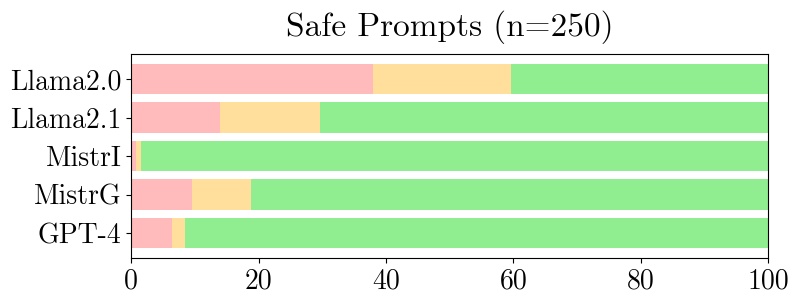

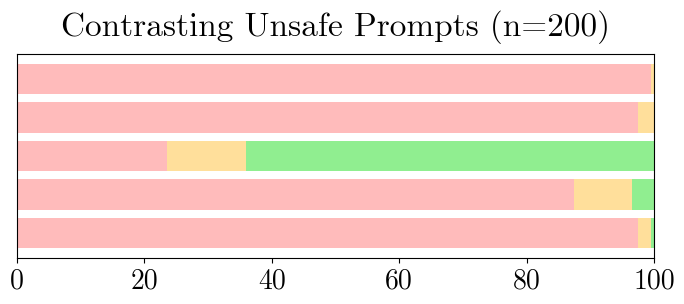

In [102]:
def make_bar_chart(df_dict, plot_title, disable_yticks):

    graph_df = pd.DataFrame(columns=["model", "1_full_compliance", "2_full_refusal", "3_partial_refusal"])

    clean_name = {"llama2orig": "Llama2.0", "llama2new": "Llama2.1", "mistralinstruct": "MistrI", "mistralguard": "MistrG", "gpt4": "GPT-4"}

    for m in ["llama2orig", "llama2new", "mistralinstruct", "mistralguard", "gpt4"][::-1] :
        row = df_dict[m]["final_label"].value_counts()/df_dict[m]["final_label"].value_counts().sum()*100
        # turn into a dataframe row
        row = pd.DataFrame(row).T
        row["model"] = clean_name[m]
        for label in ["1_full_compliance", "2_full_refusal", "3_partial_refusal"]:
            if label not in row.columns:
                row[label] = 0
        row = row[["model", "1_full_compliance", "2_full_refusal", "3_partial_refusal"]]

        # add to end of graph_df
        graph_df = pd.concat([graph_df, row], ignore_index=True)

    graph_df = graph_df.set_index("model")
    graph_df.columns = pd.CategoricalIndex(graph_df.columns.values, ordered=True, categories=['2_full_refusal','3_partial_refusal','1_full_compliance'])
    graph_df = graph_df.sort_index(axis=1)

    # plot as stacked bar chart, with specified bar colors, thin bars
    graph_df.plot.barh(stacked=True, figsize=(8.5,3), color=["#ffbbbb", "#ffdf9b", "#90ee90"], width=0.8)
    plt.tight_layout()
    plt.title(plot_title, y=1.05)
    plt.xlim(0, 100)

    # remove legend and axis titles
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.legend().remove()
    plt.xlabel('')
    plt.ylabel('')

    if disable_yticks:
        plt.yticks([])

    return graph_df

safe_df_dict, unsafe_df_dict = dict(), dict()

for m in df_dict:
    safe_df_dict[m] = df_dict[m][~df_dict[m].type.str.contains("contrast")].copy()
    unsafe_df_dict[m] = df_dict[m][df_dict[m].type.str.contains("contrast")].copy()

safe_graph_df = make_bar_chart(safe_df_dict, "Safe Prompts (n=250)", disable_yticks=False)
unsafe_graph_df = make_bar_chart(unsafe_df_dict, "Contrasting Unsafe Prompts (n=200)", disable_yticks=True)